# 05wk-1: Food-101 이미지자료의 분류

최규빈  
2024-10-04

<a href="https://colab.research.google.com/github/guebin/MP2024/blob/main/posts/05wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-xVu7C7RnIszcBO3yGUbR0s&si=vT4OKdaxP4GPQWlF>

# 2. ref

ref:
<https://huggingface.co/docs/transformers/tasks/image_classification>

# 3. imports

In [1]:
import datasets
import transformers
import torchvision.transforms
import evaluate
import numpy as np

/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

# 4. 코드정리1

In [2]:
## Step1 
### A. 데이터불러오기
food = datasets.load_dataset("food101", split="train[:5000]")
food = food.train_test_split(test_size=0.2)
### B. 전처리하기
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size), 
    torchvision.transforms.ToTensor(), 
    normalize
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)
## Step2 
### A. 인공지능을 만들기 위한 준비코드 
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
### B. 인공지능 모델만들기     
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)
## Step3 
### A. 트레이너생성을 위한 준비 
data_collator = transformers.DefaultDataCollator()
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
training_args = transformers.TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)
### B. 트레이너 생성
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)
### C. 트레이너를 이용한 학습
trainer.train()
## Step4 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

In [3]:
# Step4 
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-186")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.

In [9]:
ds = datasets.load_dataset("food101", split="validation[:10]")
image = ds["image"][0]
classifier(image)

# 5. 살펴보기

## A. 데이터불러오기

`-` 원래는 자료가 많음

In [16]:
food_full = datasets.load_dataset("food101")
food_full
# 자료가 약 10만개, 자료형은 DatasetDict 임 

`-` train에서 5000장만 가져옴

In [17]:
food5000 = datasets.load_dataset("food101", split="train[:5000]")
food5000
# 자료는 5000개, 자료형은 Dataset 


`-` `food5000`에서 8:2로 데이터를 분리

In [23]:
food = food5000.train_test_split(test_size=0.2)
food

## B. 데이터 살펴보기

`-` 이미지를 보는 방법

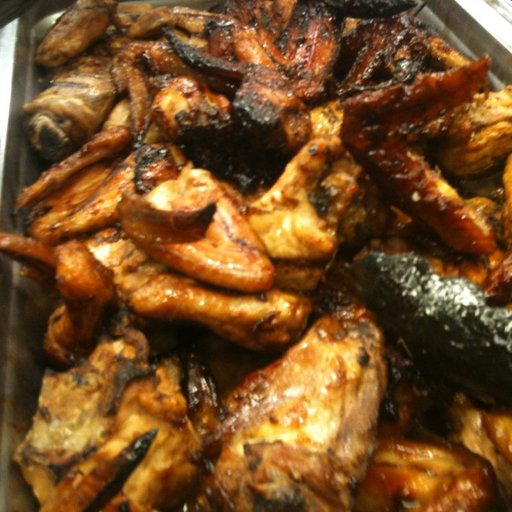

In [59]:
img = food['train'][0]['image']
img

In [61]:
type(img) # img의 자료형

`-` 이미지에 해당하는 라벨을 같이 확인하는 방법

In [63]:
# food['train'][0]['image'] --- # 0번이미지
food['train'][0]['label'] # 0번이미지에 해당하는 라벨

20이 의미하는바가 무엇이지?

In [65]:
labels = food['train'].features['label'].names # 라벨들의 정보들
labels[:5]

In [67]:
labels[20] # 20이라는 숫자가 의미하는 음식이름은 'chicken_wings' 임

정리하면

prime_rib

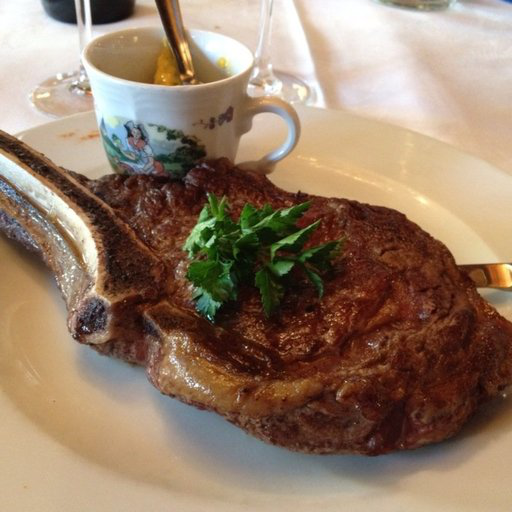

In [128]:
img_num = 11
print(labels[food['train'][img_num]['label']])
food['train'][img_num]['image']


`-` 이미지를 확인하면서 느낀점: 크기가 다름 $\to$ 각 이미지의 크기를
조사하고 싶다면?

In [117]:
# 방법1 
food['train'][3]['image'].__str__().split(' ')[-3].split("=")[-1].split("x")
sizes = [l['image'].__str__().split(' ')[-3].split("=")[-1].split("x") for l in food['train']]
sizes[:4]

In [124]:
# 방법2
sizes = [l['image'].size for l in food['train']]
sizes[:4]

-   이미지의 크기가 서로 다르네? (텍스트의 길이가 서로 다르듯이?)
-   인공지능입장에서는 이렇게 이미지의 크기가 통일되어 있지 않다면
    싫어하겠는걸?
-   이미지를 resize 하여 크기를 통일시켜주는 코드가 어딘가 반드시
    필요하겠군..

## C. `torchvision.transforms`

`-` 이미지자료 하나 받아두기

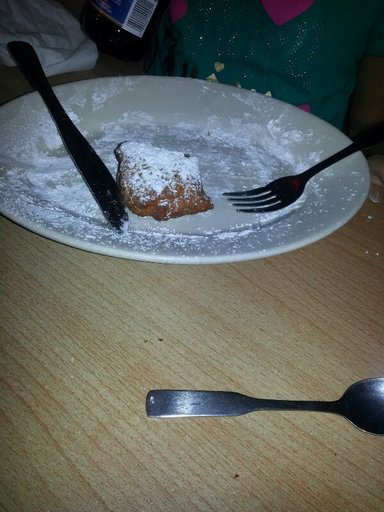

In [139]:
img = datasets.load_dataset("food101",split="train[:1]")[0]['image']
img

#### `# torchvision.transforms.RandomResizedCrop`

`# 예시1` – 사이즈를 224,112로 조정

In [159]:
자르고크기조정하기 = torchvision.transforms.RandomResizedCrop((224,112))

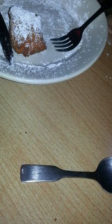

In [168]:
자르고크기조정하기(img)

`#`

`# 예시2` – 사이즈를 224,224로 조정

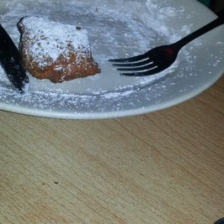

In [177]:
# 방법1
자르고크기조정하기 = torchvision.transforms.RandomResizedCrop((224,224))
자르고크기조정하기(img)

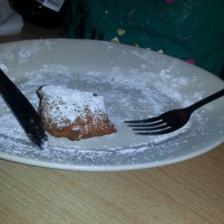

In [184]:
# 방법2
자르고크기조정하기 = torchvision.transforms.RandomResizedCrop(224)
자르고크기조정하기(img)

`#`

#### `# torchvision.transforms.ToTensor()`

`# 예시1`

In [186]:
텐서화하기 = torchvision.transforms.ToTensor()

In [189]:
텐서화하기(img)

In [190]:
텐서화하기(img).shape

`#`

`# 예시2` – `자르고크기조정하기` 와 `텐서화하기`를 동시에 사용하는 경우

In [193]:
텐서화하기(자르고크기조정하기(img)).shape

In [197]:
자르고크기조정하기(텐서화하기(img)).shape

`#`

#### `# torchvision.transforms.Normalize`

`# 예시1`

In [227]:
표준화하기 = torchvision.transforms.Normalize(mean=[10,20,30],std=[0.5,1.0,1.5])

-   `표준화하기`는 각 채널별로, `mean`을 뺸 뒤 `std`를 나눈 계산값을
    리턴한다.

In [203]:
표준화하기(텐서화하기(img)) # 숫자들이 계산됨

숫자들이 어떻게 계산되었는가?

In [217]:
print("첫번째 채널(R)")
(텐서화하기(img)[0] - 10)/0.5, 표준화하기(텐서화하기(img))[0]

첫번째 채널(R)

In [224]:
print("두번째 채널(G)")
(텐서화하기(img)[1] - 20)/1.0, 표준화하기(텐서화하기(img))[1]

두번째 채널(G)

In [225]:
print("세번째 채널(B)")
(텐서화하기(img)[2] - 30)/1.5, 표준화하기(텐서화하기(img))[2]

세번째 채널(B)

`#`

#### `# torchvision.transforms.Compose`

`# 예시1` – 여러함수를 묶어 하나의 함수를 만드는 방법

In [242]:
이미지처리하기 = torchvision.transforms.Compose([자르고크기조정하기, 텐서화하기, 표준화하기])

In [244]:
이미지처리하기(img)

`#`

## D. 이미지전처리

`-` 아래의 샘플코드를 살펴보자.

``` python
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size), 
    torchvision.transforms.ToTensor(), 
    normalize
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)
```

`# 예비학습 1`

In [251]:
a = +2
(
    (a,"음수") if a<0 else (a,"양수")
)


In [264]:
dct = {'shortest_edge':16, 'height': 224, 'width': 224}
dct = {'height': 224, 'width': 224}
(
    dct['shortest_edge'] 
    if 'shortest_edge' in dct 
    else (dct['height'],dct['width'])
)


`#`

`# 예비학습 2`

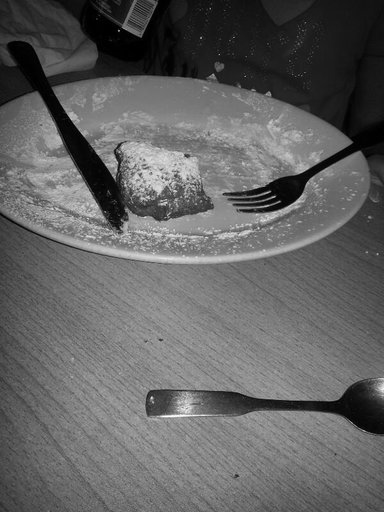

In [272]:
img.convert("L")

`#`

`-` `image_processor` 살펴보기

In [274]:
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.

In [279]:
image_processor.image_mean

In [281]:
image_processor.image_std

In [284]:
image_processor.size['height'],image_processor.size['width']

`-` 코드는 아래와 같이 단순화하여 이해할 수 있음.

In [306]:
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop((224,224)), 
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food_transformed = food.with_transform(transforms)

`-` 주의점: `food.with_transform(transforms)`는 지연처리되는 코드임

`food_transformed['train'][0:5]` 이것이 나오는 원리?

In [321]:
examples = food['train'][0:5]
transforms(examples)

## E. 모델생성

`-` 아래의 코드를 관찰하자.

In [440]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

`-` 아래와같이 해도 별로 상관없음

In [446]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [447]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

`-` `model`을 이용하여 숫자계산하기

In [466]:
model(이미지처리하기(img).reshape(1,3,224,224))

In [467]:
model(표준화하기(자르고크기조정하기(텐서화하기(img))).reshape(1,3,224,224))

## F. 데이터콜렉터

`-` 데이터 콜렉터 생성

In [496]:
data_collator = transformers.DefaultDataCollator()

`-` 데이터콜렉터에게 이번에 크게 기대하는건 없음.. 그냥 미니배치 정도만
묶어주면 됨

In [507]:
# food_transformed['train'][:2]['pixel_values']
# 이 자료는 [(3,224,224)-tensor, (3,224,224)-tensor] 와 같은 구조임
# 그런데 이 자료를 그대로 model에 넣는다면 돌아가지 않음. 
# 우리는 이 자료를 (2,3,224,224)-tensor 로 바꾸어 모델에 입력해주어야함

In [509]:
import torch
model(torch.stack(food_transformed['train'][:2]['pixel_values'],axis=0))

In [523]:
torch.stack(food_transformed['train'][:2]['pixel_values'],axis=0) # 이코드 어렵죠

In [524]:
data_collator([food['train'][0],food['train'][1]])['pixel_values'].shape # 이렇게 씀

## G. 추론

`-` 코드정리1에 의하여 이미 학습되어있는 Trainer

In [525]:
# Step4 
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-186")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.

`-` image url 에서 PIL 오브젝트 만들기: GPT 답변

``` python
from PIL import Image
import requests
from io import BytesIO

# 이미지 URL
url = "https://example.com/image.jpg"

# URL에서 이미지 불러오기
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# 이미지 확인
image.show()
```

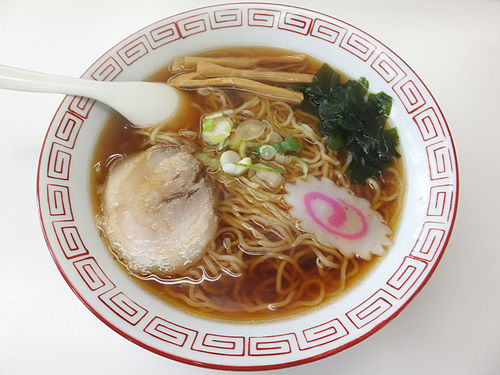

In [4]:
from PIL import Image
import requests
from io import BytesIO

# 이미지 URL
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Shoyu_ramen%2C_at_Kasukabe_Station_%282014.05.05%29_1.jpg/500px-Shoyu_ramen%2C_at_Kasukabe_Station_%282014.05.05%29_1.jpg"

# URL에서 이미지 불러오기
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image

In [5]:
classifier(image)

# 6. 코드정리2

In [541]:
## Step1 
food = datasets.load_dataset("food101", split="train[:5000]").train_test_split(test_size=0.2)
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
def transforms(examples):
    _transforms = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224), 
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    examples["pixel_values"] = [_transforms(img) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)
## Step2 
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)
## Step3 
data_collator = transformers.DefaultDataCollator()
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
training_args = transformers.TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)
trainer.train()
## Step4 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

In [542]:
# Step4 
ds = datasets.load_dataset("food101", split="validation[:10]")
image = ds["image"][0]
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-248")
classifier(image)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.